### 1. INSTALL / IMPORT LIBRARIES

In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # TODO: This can introduce misscalculations. Opt for just CPU or GPU.


import numpy as np
import faiss
import torch

from PyPDF2 import PdfReader

from openai import OpenAI
from transformers import CLIPProcessor, CLIPModel

# In your notebook (example):
from common_utils import embed_texts, embed_images, encode_image_to_base64, search_index, retrieve_context, call_gpt_4, extract_figures_from_pdf

### 2. CONFIGURE OPENAI & OTHER SETUPS

In [2]:
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")  # Make sure your OpenAI key is set
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_id)

# Create a cache dictionary in memory
# response_cache = {}

### 4. PROCESS THE PDF (TEXT + IMAGES)

In [ ]:
PDF_FILE = "../knowledge/catsanddogs.pdf"

text_data = []
image_data = []

# Extract text
reader = PdfReader(PDF_FILE)
num_pages = len(reader.pages)

for page_i in range(num_pages):
    page = reader.pages[page_i]
    page_text = page.extract_text()
    
    if page_text and page_text.strip():
        text_data.append({
            "text": page_text.strip(),
            "page_number": page_i + 1
        })

# Extract images
all_images = extract_figures_from_pdf(PDF_FILE)
print(f"Extracted {len(all_images)} images.")

for i, pil_img in enumerate(all_images):
    image_data.append({
        "image": pil_img,
        "image_number": i + 1
    })

### 5. CREATE EMBEDDINGS FOR TEXT AND IMAGE CHUNKS

In [4]:
all_metadata = []
all_embeddings = []

#### 5A. Embed all text chunks

In [5]:
texts_list = [td["text"] for td in text_data]
if len(texts_list) > 0:
    text_embeddings = embed_texts(texts_list, clip_processor, clip_model)
    for i, emb in enumerate(text_embeddings):
        all_metadata.append({
            "type": "text",
            "content": text_data[i]["text"],
            "page_number": text_data[i]["page_number"]
        })
        all_embeddings.append(emb)

#### 5B. Embed all images

In [6]:
pil_images_list = [id_["image"] for id_ in image_data]
if len(pil_images_list) > 0:
    image_embeddings = embed_images(pil_images_list, clip_processor, clip_model)
    for i, emb in enumerate(image_embeddings):
        
        # Convert PIL image to base64 once (so we can send it to GPT-4 with Vision)
        base64_str = encode_image_to_base64(image_data[i]["image"])
        
        all_metadata.append({
            "type": "image",
            # Store the base64 data directly as "content"
            "content": base64_str,
            "image_number": image_data[i]["image_number"]
        })
        all_embeddings.append(emb)

# Convert to NumPy array
all_embeddings = np.array(all_embeddings).astype('float32')
embedding_dimension = all_embeddings.shape[1]

### 6. BUILD & POPULATE FAISS

In [7]:
# Create and return a flat Faiss index of the specified dimension.
index = faiss.IndexFlatIP(embedding_dimension)

# Add embeddings to a Faiss index.
index.add(all_embeddings)

### 7. QUERY PIPELINE (RETRIEVAL + GENERATION)

In [8]:
def answer_query(user_query, top_k=3):
    """
    1. Embed the user query (as text).
    2. Retrieve top_k similar items from the PDF (text or image).
    3. Build a ChatCompletion messages list with text + images.
    4. Return GPT-4's answer.
    """
    # Step 1: Embed user query
    query_emb = embed_texts([user_query], clip_processor, clip_model)  # shape: (1, D)
    
    # Step 2: Retrieve from Faiss
    distances, faiss_indices = search_index(index, query_emb, top_k=top_k)
    retrieved_items = retrieve_context(faiss_indices, all_metadata)
    print("Distances:", distances)

    # Step 3: Build the messages payload
    # We'll pass the user's question as the first part of the content,
    # then each retrieved item (text or image) as separate parts.
    user_content = []
    
    # Add user query
    user_content.append({"type": "text", "text": f"User query: {user_query}"})
    
    # Add each retrieved item
    for item in retrieved_items:
        if item["type"] == "text":
            # Provide textual snippet
            user_content.append({
                "type": "text",
                "text": f"(page {item['page_number']}) {item['content'][:500]}..."
            })
        elif item["type"] == "image":
            # Provide the base64 image data as a data URI
            base64_str = item["content"]
            user_content.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{base64_str}"
                }
            })

    # Step 4: Call GPT-4 with the full message payload
    answer = call_gpt_4(user_content)
    return answer

### 8. EXAMPLE USAGE

Distances: [[0.7718457  0.5225174  0.26550642]]
[{'role': 'system', 'content': ''}, {'role': 'user', 'content': [{'type': 'text', 'text': 'User query: What are the dog names?'}, {'type': 'text', 'text': '(page 1) This\n \nis\n \nwhat\n \ndogs\n \nlike\n \nto\n \ndo.\n \n \nHere\n \nis\n \nRuffy,\n \na\n \ndog\n \nthat\n \nis\n \nblack\n \nand\n \nwhite...'}, {'type': 'text', 'text': '(page 2) This\n \nis\n \nBunny ,\n \na\n \nbulldog\n \nthat\n \nlikes\n \nto\n \ndo\n \nwhat\n \nthe\n \nimage\n \nillustrates.\n \n \nWeiner\n \nis\n \na\n \ndog\n \nthat\n \nlikes\n \nto\n \nwear\n \na\n \nsweater\n \nwhile\n \nhe\n \ndoes\n \nhis\n \nfavourite\n \nactivity ,\n \nas\n \nyou\n \ncan\n \nsee\n \non\n \nthe\n \nimage....'}, {'type': 'image_url', 'image_url': {'url': ''}}]}]

Q: What are the dog names?
A: The dog names mentioned in your text are:

1. Ruffy
2. Bunny
3. Weiner

If you need more information about these dogs or their activities, feel free to ask!

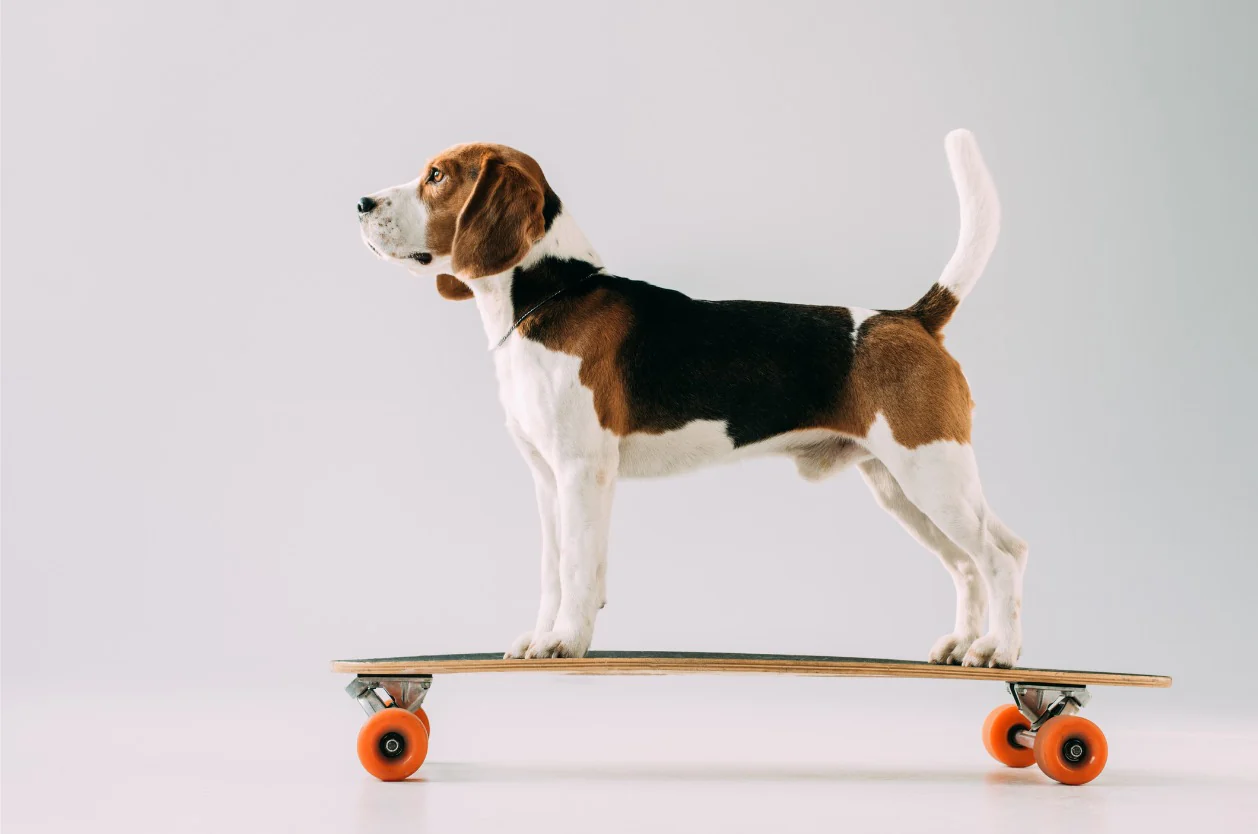

In [11]:
user_query_1 = "What are the dog names?"
response_1 = answer_query(user_query_1, top_k=3)
print("\nQ:", user_query_1)
print("A:", response_1)